In [596]:
import numpy as np
import pandas as pd
import time
import math
import bs4
from random import randint
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
import torch.nn.functional as F

In [597]:
pure_training_dataset = pd.read_csv('./data/lol.csv')

team_features = ["tower", "dragon", "baron"]
team_positions = ["blue", "red"]
player_features = ["kill", "death", "assist", "CSM", "GPM", "G%", "VSPM", "WPM", "VMPM", "WCPM", "VS%", "DPM", "DMG%", "GD@15", "CSD@15", "XPD@15", "DT"]
player_positions = ["TOP", "JG", "MID", "AD", "SUP"]

column = ["title", "tournament", "tag", "date", "blue_team", "red_team", "label", "gametime"]
for team_position in team_positions:
    for team_feature in team_features:
        column.append(team_position+"_"+team_feature)
    for player_feature in player_features:
        for player_position in player_positions:
            column.append(team_position+"_"+player_position+"_"+player_feature)

pure_training_dataset.columns = column

gametimes = []
for gametime in pure_training_dataset['gametime']:
    # print(gametime)
    gametimes.append(int(gametime.split(':')[0])*60+int(gametime.split(':')[1]))
pure_training_dataset['gametime'] = gametimes

display(pure_training_dataset)

,title,tournament,tag,date,blue_team,red_team,label,gametime,blue_tower,blue_dragon,...,red_TOP_XPD@15,red_JG_XPD@15,red_MID_XPD@15,red_AD_XPD@15,red_SUP_XPD@15,red_TOP_DT,red_JG_DT,red_MID_DT,red_AD_DT,red_SUP_DT
0,CES vs Team Secret game 1,VCS Winter 2021,WEEK3,2021-12-05,Cerberus Esports,Team Secret,blue,2299,9.0,4.0,...,310.0,-1311.0,-496.0,-754.0,304.0,36232.0,31538.0,25049.0,22032.0,24104.0
1,CES vs Team Secret game 2,VCS Winter 2021,WEEK3,2021-12-05,Team Secret,Cerberus Esports,red,2015,1.0,0.0,...,626.0,-422.0,-220.0,1287.0,-719.0,48776.0,36696.0,27086.0,23365.0,22935.0
2,SE vs SGB game 1,VCS Winter 2021,WEEK3,2021-12-05,SBTC Esports,Saigon Buffalo,blue,1879,9.0,2.0,...,460.0,607.0,1022.0,630.0,-208.0,18480.0,31414.0,21879.0,13656.0,13731.0
3,SE vs SGB game 2,VCS Winter 2021,WEEK3,2021-12-05,Saigon Buffalo,SBTC Esports,blue,1726,8.0,1.0,...,-1739.0,-190.0,24.0,224.0,222.0,22057.0,28535.0,23088.0,10195.0,11937.0
4,SE vs SGB game 3,VCS Winter 2021,WEEK3,2021-12-05,SBTC Esports,Saigon Buffalo,blue,1918,7.0,2.0,...,-429.0,-808.0,-797.0,585.0,187.0,30205.0,30271.0,17178.0,13344.0,13509.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20841,Gentside vs Solary game 1,Challenge France 2017,WEEK1,2017-11-11,Gentside,Solary,blue,1625,10.0,2.0,...,-1203.0,-1147.0,806.0,1104.0,-668.0,13890.0,23248.0,13159.0,11989.0,9329.0
20842,Millenium vs Asus ROG game 1,Challenge France 2017,WEEK1,2017-11-11,Millenium,Asus ROG,blue,2017,11.0,2.0,...,-56.0,-1121.0,311.0,-136.0,-897.0,18393.0,28221.0,19140.0,14229.0,10637.0
20843,GO vs Solary game 1,Challenge France 2017,WEEK1,2017-11-10,Gamers Origin,Solary,red,1930,5.0,1.0,...,-1121.0,92.0,182.0,-744.0,-96.0,37124.0,32267.0,11751.0,16018.0,21218.0
20844,Team LDLC vs Asus ROG game 1,Challenge France 2017,WEEK1,2017-11-10,Team LDLC,Asus ROG,blue,1400,9.0,1.0,...,-1106.0,-958.0,-941.0,-208.0,-924.0,17369.0,14044.0,9597.0,8171.0,10358.0


blue    11161
red      9685
Name: label, dtype: int64


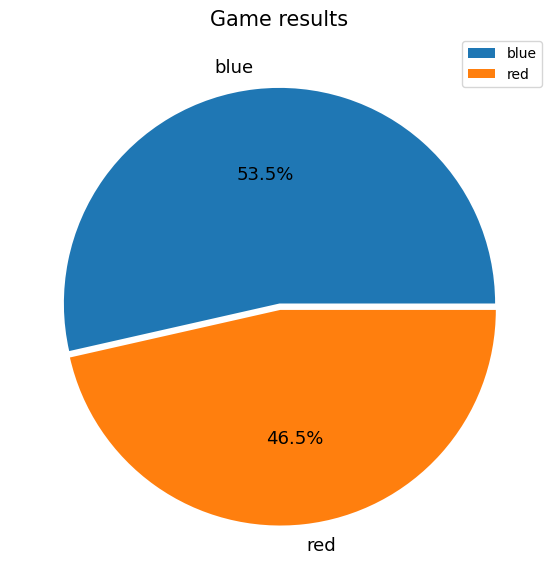

2021    6823
2020    5620
2019    4374
2018    3944
2017      85
dtype: int64


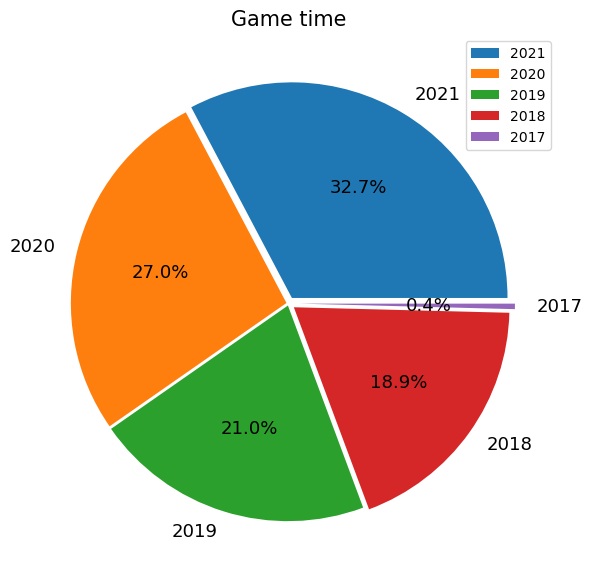

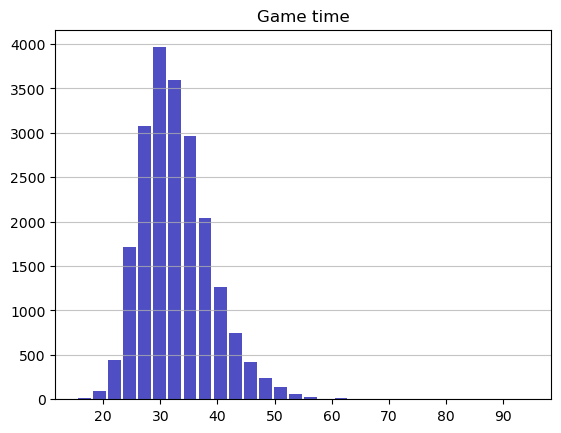

In [173]:
print(pure_training_dataset['label'].value_counts())

plt.figure(figsize=(7, 7))
plt.pie(pure_training_dataset['label'].value_counts(),
       labels = ['blue', 'red'],
       autopct = "%1.1f%%",
       explode = [0, 0.03],
       textprops = {"fontsize" : 13})
plt.legend(loc="best")
plt.title('Game results',  {"fontsize" : 15})
plt.show()

print(pd.DataFrame([data.split('-')[0] for data in pure_training_dataset['date']]).value_counts())
plt.figure(figsize=(7, 7))
plt.pie(pd.DataFrame([data.split('-')[0] for data in pure_training_dataset['date']]).value_counts(),
       labels = ['2021', '2020', '2019', '2018', '2017'],
       autopct = "%1.1f%%",
       explode = [0.03, 0.01, 0.01, 0.03, 0.05],
       textprops = {"fontsize" : 13})
plt.legend(loc="best")
plt.title('Game time',  {"fontsize" : 15})
plt.show()

plt.figure()
plt.hist(pure_training_dataset['gametime']/60, bins=30, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.title('Game time')
plt.show()

In [721]:
pure_training_dataset = pure_training_dataset.sort_values(['date', 'title'], ascending=True)

df = []
inv_df = []
blue_feature = dict()
red_feature = dict()
start_tournaments = [
    'KeSPA Cup 2020',
    'Kespa Cup 2019',
    'Kespa Cup Playoffs 2018',
    'Kespa Cup 2017',
    'MSI 2021',
    'MSI Play-In 2019',
    'MSI Play-In 2018',
    'MSI Play-In 2017',
]
exp = 3
seed = 1225
np.random.seed(seed)
for data in pure_training_dataset.iloc:
    blue_team, red_team = data['blue_team'], data['red_team']
    blue_info, red_info = data.iloc[8:96].tolist(), data.iloc[96:].tolist()
    gametime = data.iloc[7]
    
    if data['tournament'] in start_tournaments:
        blue_feature = dict()
        red_feature = dict()
        start_tournaments.remove(data['tournament'])
       
    if blue_team in blue_feature.keys() and red_team in red_feature.keys() and \
        red_team in blue_feature.keys() and blue_team in red_feature.keys() and \
        len(blue_feature[blue_team]) == exp and len(red_feature[red_team]) == exp and \
        len(blue_feature[red_team]) == exp and len(red_feature[blue_team]) == exp:
        
        label = 0 if data['label'] == 'blue' else 1 
        rev_label = 1 if data['label'] == 'blue' else 0
        b1 = np.array(blue_feature[blue_team]).mean(0)
        r1 = np.array(red_feature[blue_team]).mean(0)
        b2 = np.array(blue_feature[red_team]).mean(0)
        r2 = np.array(red_feature[red_team]).mean(0)
        
        target = np.random.randint(0, 2)
        if target == label:
            df.append(np.concatenate((b1, r1, b2, r2), axis=0).tolist() + [label])
            inv_df.append(np.concatenate((b2, r2, b1, r1), axis=0).tolist() + [rev_label])
        else:
            df.append(np.concatenate((b2, r2, b1, r1), axis=0).tolist() + [rev_label])
            inv_df.append(np.concatenate((b1, r1, b2, r2), axis=0).tolist() + [label])
        
    if blue_team not in blue_feature.keys():
        blue_feature[blue_team] = [np.array([gametime] + blue_info)]
    else:
        if len(blue_feature[blue_team]) == exp: blue_feature[blue_team].pop(0) 
        blue_feature[blue_team].append(np.array([gametime] + blue_info))
        
    if red_team not in red_feature.keys(): 
        red_feature[red_team] = [np.array([gametime] + blue_info)]
    else:
        if len(red_feature[red_team]) == exp: red_feature[red_team].pop(0)
        red_feature[red_team].append(np.array([gametime] + red_info))
        
df = pd.DataFrame(df)
inv_df = pd.DataFrame(inv_df)
print(df.shape)

(14700, 357)


In [722]:
df = shuffle(df, random_state=seed)
x = np.array(df.iloc[:, :-1])
x = preprocessing.scale(x)
y = np.array(df.iloc[:, -1])
x_train, x_test = x[:math.floor(len(x)*0.8)], x[math.floor(len(x)*0.8):]
y_train, y_test = y[:math.floor(len(y)*0.8)], y[math.floor(len(y)*0.8):]

inv_df = shuffle(inv_df, random_state=seed)
inv_x = np.array(inv_df.iloc[:, :-1])
inv_x = preprocessing.scale(inv_x)
inv_y = np.array(df.iloc[:, -1])
inv_x_train, inv_x_test = inv_x[:math.floor(len(inv_x)*0.8)], inv_x[math.floor(len(inv_x)*0.8):]
inv_y_train, inv_y_test = inv_y[:math.floor(len(inv_y)*0.8)], inv_y[math.floor(len(inv_y)*0.8):]

In [723]:
myNB = GaussianNB()
myNB.fit(x_train, y_train)

y_pred_prob = myNB.predict_proba(x_test)
inv_y_pred_prob = myNB.predict_proba(inv_x_test)
for idx in range(len(x_test)):
    y_pred_prob[idx][0] += inv_y_pred_prob[idx][1]
    y_pred_prob[idx][1] += inv_y_pred_prob[idx][0]
    y_pred_prob[idx][0] /= 2
    y_pred_prob[idx][1] /= 2
y_pred = np.array([np.argmax(prob) for prob in y_pred_prob])
display(pd.DataFrame(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))

,0,1
0,926,562
1,555,897


              precision    recall  f1-score   support

           0       0.63      0.62      0.62      1488
           1       0.61      0.62      0.62      1452

    accuracy                           0.62      2940
   macro avg       0.62      0.62      0.62      2940
weighted avg       0.62      0.62      0.62      2940



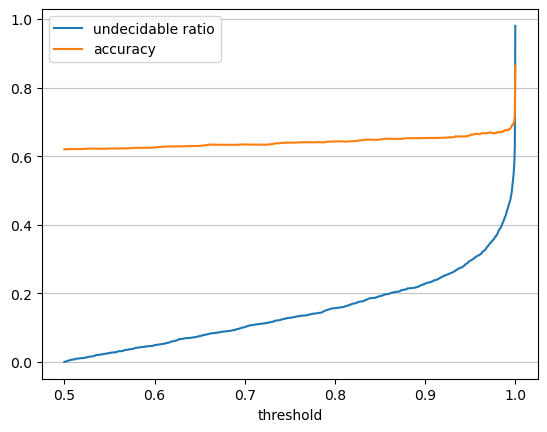

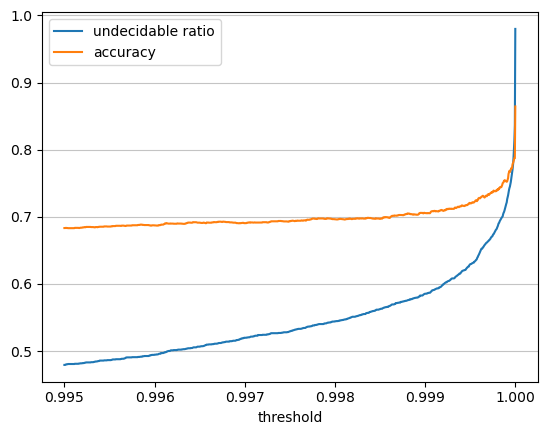

In [727]:
thresholds = np.linspace(0.5, 1-1e-9, 1000)
undecidable_ratio = []
accuracy_list = []
for threshold in thresholds:
    indices = [idx for idx in range(len(y_pred)) if y_pred_prob[idx][y_pred[idx]] > threshold]
    undecidable_ratio.append(1 - len(indices)/len(y_pred))
    accuracy_list.append(accuracy_score(y_test[indices], y_pred[indices]))
    
plt.figure()
plt.plot(thresholds, undecidable_ratio, label="undecidable ratio")
plt.plot(thresholds, accuracy_list, label="accuracy")
plt.xlabel('threshold')
plt.grid(axis='y', alpha=0.75)
plt.legend(loc="best")
plt.show()

thresholds = np.linspace(0.995, 1-1e-9, 1000)
undecidable_ratio = []
accuracy_list = []
for threshold in thresholds:
    indices = [idx for idx in range(len(y_pred)) if y_pred_prob[idx][y_pred[idx]] > threshold]
    undecidable_ratio.append(1 - len(indices)/len(y_pred))
    accuracy_list.append(accuracy_score(y_test[indices], y_pred[indices]))
    
plt.figure()
plt.plot(thresholds, undecidable_ratio, label="undecidable ratio")
plt.plot(thresholds, accuracy_list, label="accuracy")
plt.xlabel('threshold')
plt.grid(axis='y', alpha=0.75)
plt.legend(loc="best")
plt.show()

In [748]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1000)
myknn = knn.fit(x_train, y_train)

y_pred_prob = myknn.predict_proba(x_test)
inv_y_pred_prob = myknn.predict_proba(inv_x_test)
for idx in range(len(x_test)):
    y_pred_prob[idx][0] += inv_y_pred_prob[idx][1]
    y_pred_prob[idx][1] += inv_y_pred_prob[idx][0]
    y_pred_prob[idx][0] /= 2
    y_pred_prob[idx][1] /= 2
y_pred = np.array([np.argmax(prob) for prob in y_pred_prob])
display(pd.DataFrame(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))

,0,1
0,928,560
1,553,899


              precision    recall  f1-score   support

           0       0.63      0.62      0.63      1488
           1       0.62      0.62      0.62      1452

    accuracy                           0.62      2940
   macro avg       0.62      0.62      0.62      2940
weighted avg       0.62      0.62      0.62      2940



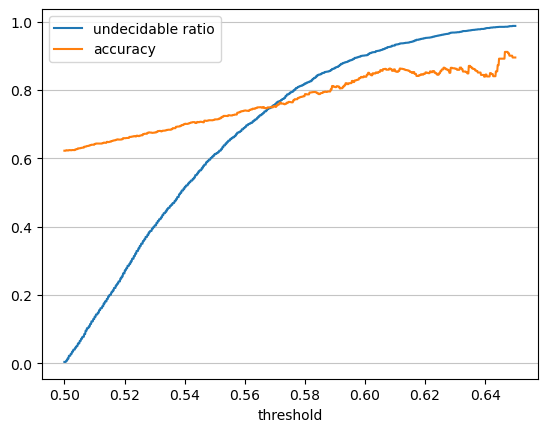

In [751]:
thresholds = np.linspace(0.5, 0.65, 1000)
undecidable_ratio = []
accuracy_list = []
for threshold in thresholds:
    indices = [idx for idx in range(len(y_pred)) if y_pred_prob[idx][y_pred[idx]] > threshold]
    undecidable_ratio.append(1 - len(indices)/len(y_pred))
    accuracy_list.append(accuracy_score(y_test[indices], y_pred[indices]))
    
plt.figure()
plt.plot(thresholds, undecidable_ratio, label="undecidable ratio")
plt.plot(thresholds, accuracy_list, label="accuracy")
plt.xlabel('threshold')
plt.grid(axis='y', alpha=0.75)
plt.legend(loc="best")
plt.show()

In [725]:
class myDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        # label is required to be a LongTensor
        self.y = torch.LongTensor(y)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        Y = self.y[index]
        return X, Y
    
batch_size = 32
train_set = myDataset(x_train, y_train)
val_set = myDataset(x_test, y_test)
inv_val_set = myDataset(inv_x_test, inv_y_test)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
inv_val_loader = DataLoader(inv_val_set, batch_size=batch_size, shuffle=False)

class DNN_model(nn.Module):
    def __init__(self):
        super(DNN_model, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(356, 256), 
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.7), 
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.7),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.7),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = x.view(-1,356)
        return self.fc(x)

model = DNN_model().cuda()

summary(model, (356, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          91,392
              ReLU-2                  [-1, 256]               0
       BatchNorm1d-3                  [-1, 256]             512
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 256]          65,792
              ReLU-6                  [-1, 256]               0
       BatchNorm1d-7                  [-1, 256]             512
           Dropout-8                  [-1, 256]               0
            Linear-9                  [-1, 256]          65,792
             ReLU-10                  [-1, 256]               0
      BatchNorm1d-11                  [-1, 256]             512
          Dropout-12                  [-1, 256]               0
           Linear-13                    [-1, 2]             514
Total params: 225,026
Trainable params:

In [726]:
model = DNN_model().cuda()

loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-3) # optimizer 使用 Adam
num_epoch = 100

best_val_acc = 0
for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = model(data[0].float().cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        batch_loss = loss(train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
    
    model.eval()
    with torch.no_grad():
        for data, inv_data in zip(val_loader, inv_val_loader):
            val_pred = model(data[0].float().cuda())
            inv_val_pred = model(inv_data[0].float().cuda())
            for idx in range(len(data)):
                val_pred[idx][0] += inv_val_pred[idx][1]
                val_pred[idx][1] += inv_val_pred[idx][0]
                val_pred[idx][0] /= 2
                val_pred[idx][1] /= 2
            
            batch_loss = loss(val_pred, data[1].cuda())

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()

        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))
        
    if best_val_acc < val_acc/val_set.__len__():
        best_val_acc = val_acc/val_set.__len__()
        torch.save(model, './model/model.pt')

    # if best_val_acc > 0.625:
    #     optimizer = torch.optim.SGD(model.parameters(), lr=5e-5, weight_decay=0, momentum=0.9)
        
print('best val acc: {}'.format(best_val_acc))

[001/100] 1.29 sec(s) Train Acc: 0.510884 Loss: 0.027269 | Val Acc: 0.529252 loss: 0.021678
[002/100] 1.12 sec(s) Train Acc: 0.529762 Loss: 0.024368 | Val Acc: 0.577891 loss: 0.021061
[003/100] 1.15 sec(s) Train Acc: 0.535799 Loss: 0.023328 | Val Acc: 0.601361 loss: 0.020858
[004/100] 1.15 sec(s) Train Acc: 0.547789 Loss: 0.022180 | Val Acc: 0.607823 loss: 0.020760
[005/100] 1.15 sec(s) Train Acc: 0.558588 Loss: 0.021866 | Val Acc: 0.609184 loss: 0.020714
[006/100] 1.20 sec(s) Train Acc: 0.564201 Loss: 0.021511 | Val Acc: 0.619388 loss: 0.020585
[007/100] 1.18 sec(s) Train Acc: 0.579252 Loss: 0.021232 | Val Acc: 0.620068 loss: 0.020552
[008/100] 1.17 sec(s) Train Acc: 0.582823 Loss: 0.021057 | Val Acc: 0.623810 loss: 0.020439
[009/100] 1.14 sec(s) Train Acc: 0.591922 Loss: 0.020853 | Val Acc: 0.620748 loss: 0.020367
[010/100] 1.12 sec(s) Train Acc: 0.597534 Loss: 0.020729 | Val Acc: 0.629252 loss: 0.020356
[011/100] 1.17 sec(s) Train Acc: 0.600170 Loss: 0.020758 | Val Acc: 0.619728 los

[091/100] 1.19 sec(s) Train Acc: 0.759184 Loss: 0.015653 | Val Acc: 0.601020 loss: 0.022438
[092/100] 1.18 sec(s) Train Acc: 0.753656 Loss: 0.015765 | Val Acc: 0.606463 loss: 0.022184
[093/100] 1.11 sec(s) Train Acc: 0.755952 Loss: 0.015744 | Val Acc: 0.604422 loss: 0.022069
[094/100] 1.16 sec(s) Train Acc: 0.762670 Loss: 0.015584 | Val Acc: 0.607823 loss: 0.022551
[095/100] 1.18 sec(s) Train Acc: 0.754337 Loss: 0.015642 | Val Acc: 0.601701 loss: 0.022248
[096/100] 1.19 sec(s) Train Acc: 0.759609 Loss: 0.015730 | Val Acc: 0.603741 loss: 0.022513
[097/100] 1.17 sec(s) Train Acc: 0.764711 Loss: 0.015319 | Val Acc: 0.596259 loss: 0.022739
[098/100] 1.18 sec(s) Train Acc: 0.758248 Loss: 0.015689 | Val Acc: 0.607483 loss: 0.022123
[099/100] 1.20 sec(s) Train Acc: 0.759354 Loss: 0.015537 | Val Acc: 0.606803 loss: 0.022498
[100/100] 1.17 sec(s) Train Acc: 0.761054 Loss: 0.015524 | Val Acc: 0.606122 loss: 0.022481
best val acc: 0.6292517006802721


In [729]:
model = torch.load('./model/best_model.pt')
y_pred_prob = model(torch.tensor(x_test).float().cuda()).cpu().detach().numpy()
inv_y_pred_prob = model(torch.tensor(inv_x_test).float().cuda()).cpu().detach().numpy()
for idx in range(len(x_test)):
    y_pred_prob[idx][0] += inv_y_pred_prob[idx][1]
    y_pred_prob[idx][1] += inv_y_pred_prob[idx][0]
    sum_ = np.exp(y_pred_prob[idx][0])+np.exp(y_pred_prob[idx][1])
    y_pred_prob[idx][0] = np.exp(y_pred_prob[idx][0])/sum_
    y_pred_prob[idx][1] = np.exp(y_pred_prob[idx][1])/sum_
y_pred = np.array([np.argmax(prob) for prob in y_pred_prob])
display(pd.DataFrame(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))

,0,1
0,933,555
1,539,913


              precision    recall  f1-score   support

           0       0.63      0.63      0.63      1488
           1       0.62      0.63      0.63      1452

    accuracy                           0.63      2940
   macro avg       0.63      0.63      0.63      2940
weighted avg       0.63      0.63      0.63      2940



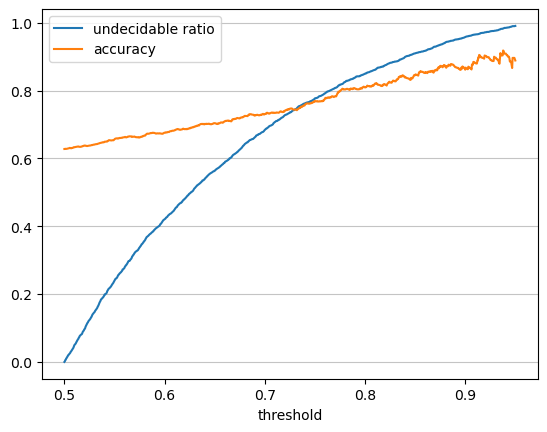

In [730]:
thresholds = np.linspace(0.5, 0.95, 1000)
undecidable_ratio = []
accuracy_list = []
for threshold in thresholds:
    indices = [idx for idx in range(len(y_pred)) if y_pred_prob[idx][y_pred[idx]] > threshold]
    undecidable_ratio.append(1 - len(indices)/len(y_pred))
    accuracy_list.append(accuracy_score(y_test[indices], y_pred[indices]))
    
plt.figure()
plt.plot(thresholds, undecidable_ratio, label="undecidable ratio")
plt.plot(thresholds, accuracy_list, label="accuracy")
plt.xlabel('threshold')
plt.grid(axis='y', alpha=0.75)
plt.legend(loc="best")
plt.show()

In [ ]:
pure_training_dataset = pure_training_dataset.sort_values(['date', 'title'], ascending=True)

game_results = dict()
for data in pure_training_dataset.iloc:
    win_team = data['blue_team'] if data['label'] == 'blue' else data['red_team']
    title = data['title'].split('game')[0] + data['tournament']
    
    if title not in game_results.keys():
        game_results[title] = [win_team]
    else:
        game_results[title].append(win_team)
    
game_final_results = dict()
for key in game_results:
    # if len(game_results[key]) == 1: continue
    win_team = max(game_results[key],key=game_results[key].count)
    game_final_results[key] = win_team
    
df = []
exp = 6
team_feature = dict()
start_tournaments = [
    'KeSPA Cup 2020',
    'Kespa Cup 2019',
    'Kespa Cup Playoffs 2018',
    'Kespa Cup 2017',
    'MSI 2021',
    'MSI Play-In 2019',
    'MSI Play-In 2018',
    'MSI Play-In 2017',
]
for data in pure_training_dataset.iloc:
    title = data['title'].split('game')[0] + data['tournament']
    blue_team, red_team = data['blue_team'], data['red_team']
    blue_info, red_info = data.iloc[8:96].tolist(), data.iloc[96:].tolist()
    gametime = data.iloc[7]
    
    if data['tournament'] in start_tournaments:
        team_feature = dict()
        start_tournaments.remove(data['tournament'])
       
    if blue_team in team_feature.keys() and red_team in team_feature.keys() and \
        len(team_feature[blue_team]) == exp and len(team_feature[red_team]) == exp and \
        title in game_final_results.keys() and data['title'].split('game ')[1] == '1':
    
        label = 0 if game_final_results[title] == blue_team else 1 
        rev_label = 1 if game_final_results[title] == blue_team else 0
        
        df.append((np.array(team_feature[blue_team]).mean(0).tolist() + np.array(team_feature[red_team]).mean(0).tolist()) + [label])
        df.append((np.array(team_feature[red_team]).mean(0).tolist() + np.array(team_feature[blue_team]).mean(0).tolist()) + [rev_label])

    
    if blue_team not in team_feature.keys():
        team_feature[blue_team] = [np.array([gametime] + blue_info)]
    else:
        if len(team_feature[blue_team]) == exp: team_feature[blue_team].pop(0) 
        team_feature[blue_team].append(np.array([gametime] + blue_info))
        
    if red_team not in team_feature.keys(): 
        team_feature[red_team] = [np.array([gametime] + blue_info)]
    else:
        if len(team_feature[red_team]) == exp: team_feature[red_team].pop(0)
        team_feature[red_team].append(np.array([gametime] + red_info))
        
print(pd.DataFrame(df).shape)